In [1]:
using Flux, CSV, DataFrames
using Flux.Data:DataLoader
using Flux: onehotbatch, onecold
using MLJ: unpack, partition
using Flux.Losses: logitcrossentropy
using Plots
cd("/home/vv/IsingModelPractice")

## Load Data
note the reshaping of X into matricies and 
y to a one hot vector, requires labels

In [2]:
labels = [-32, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 32]
# Load Data ---------------------------------------------------------
test = []
train = []

RealtivePath = "Data/Energy w All_4x4_flat.csv"
df_energies = CSV.read("$RealtivePath", DataFrame)



# n = convert(Int,sqrt(size(df_energies)[2]-1))
# N = convert(Int,size(df_energies)[1])

y, X = unpack(df_energies, ==(:energies), !=(:energies))


X = convert(Matrix, X)
global train, test = partition(eachindex(y), 0.25, shuffle=true) 
X_train, X_test = reshape(X[train,:], 4,4,1,:), reshape(X[test, :],4,4,1,:)
y_train, y_test = onehotbatch(y[train], labels), onehotbatch(y[test], labels)

train_loader = DataLoader((X_train, y_train), batchsize=100) # no need to shuffle, already atchieved through rand
test_loader = DataLoader((X_test, y_test))




DataLoader{Tuple{Array{Int64,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}}}(([1 1 -1 1; -1 -1 -1 1; -1 -1 1 -1; -1 1 1 1]

[-1 -1 1 -1; -1 1 1 -1; 1 1 -1 -1; 1 1 -1 -1]

[-1 -1 -1 -1; -1 -1 1 1; -1 1 -1 1; 1 1 1 -1]

...

[1 -1 -1 -1; 1 -1 1 1; -1 -1 -1 1; 1 -1 1 1]

[1 1 1 -1; -1 1 -1 1; -1 -1 1 1; -1 1 1 1]

[1 1 -1 -1; -1 -1 -1 1; 1 -1 1 -1; 1 -1 1 1], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 1, 49152, true, 49152, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  49143, 49144, 49145, 49146, 49147, 49148, 49149, 49150, 49151, 49152], false)

## CNN
The loss is copied, I don't fully understand it
 
The net is a single 2x2 filter with ReLU into a Dense layer

In [4]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

model =  Chain(
    Conv((2,2),1=>1,pad=(1,1),relu),
    Flux.flatten,
    Dense(25,64,relu),
    Dense(64, 15)
    )
    print(model(ones(4,4,1,1))) #this precomples the model


┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float64
│   T1 = Float64
│   T2 = Float32
└ @ NNlib /home/vv/.julia/packages/NNlib/xpcWJ/src/conv.jl:206
Float32[0.010288436; 0.018007131; 0.004481571; -0.028398667; 0.001723283; 0.009697853; 0.006309973; -0.024325233; 0.015276587; 0.019139042; -0.017187938; 0.00091150135; -0.0112712905; -0.0007625185; -0.0025712522]

## Training of the network
The x |> cpu pipes x to cpu, x |> gpu also works, but my gpu isn't set up for it

I don't fully understand this 


In [10]:
opt = ADAM()

ps = Flux.params(model) 
acc=0
ntot=0
for epoch in 1:10
    for (x,y) in train_loader
        x, y = x |> gpu, y |> gpu 
        gs = Flux.gradient(ps) do 
            ŷ = model(x)
            loss(ŷ, y)                
        end
        Flux.Optimise.update!(opt, ps, gs)
    end
    return (loss)
end


loss (generic function with 1 method)

## Reslut analysis
Error per energy and predicted energy list

In [6]:
ladles = Dict([(i,[]) for i in labels])
ys = []
y_news = []
for (x,y) in test_loader
    y = Int(onecold(y)[1]) # this returns in 1:15 range
    y = labels[y] #1:15 to [-32, -24, ..., 24, 32]
    push!(ys, y)
    y_new = onecold(model(x))[1]
    y_new = labels[y_new]
    push!(y_news, y_new)
    error_mine = y - y_new
    push!(ladles[y], error_mine)
end


average error per energy

In [17]:
avgs = []
for i in labels
    avg = sum(ladles[i])/size(ladles[i])[end]
    push!(avgs, avg)
end


In [19]:
avgs

15-element Array{Any,1}:
 -32.0
 -24.0
 -20.0
 -16.062111801242235
 -12.052509652509652
  -8.02063492063492
  -4.042279956534624
  -0.03667100130039012
   3.9565217391304346
   7.955289421157684
  11.993865030674847
  15.949685534591195
  19.6
  24.16
  34.0

# Plots

Average error per energy

In [9]:
println(unique(y_news))
println(unique(ys))


Any[0, -4, 4, -8, 8]
Any[0, 8, -4, -8, -12, 4, 12, -16, 16, -20, 24, 20, -24, 32, -32]


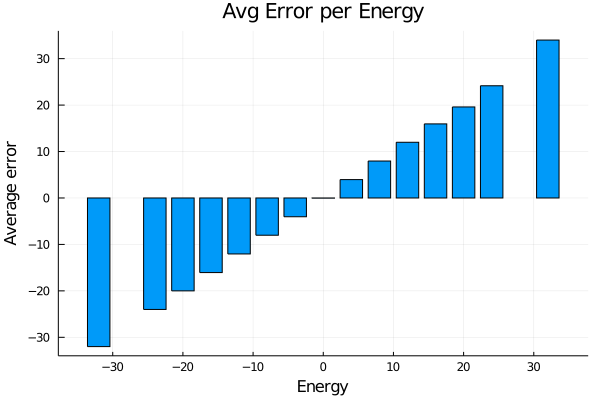

In [27]:
bar(labels, avgs, bins=15, legend=false, title="Avg Error per Energy", xlabel="Energy", ylabel="Average error")

In [ ]:
plot(ys,y_news,seriestype = :scatter)